In [1]:
import subprocess
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import copy 
import os
import glob
import warnings
from os.path import join as pjoin
import utils
import scipy.io
import nilearn
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain

def mkdir_no_exist(d): os.makedirs(d, exist_ok=True)

from nilearn.plotting import plot_img, plot_glass_brain
import matplotlib.pyplot as plt


# repetition has to be known
TR = 0.72 

In [2]:
def pretty_print(files, n_toprint=None, basepath=False):
    to_print = files
    if n_toprint is not None:
        to_print = to_print[:n_toprint]
    for f in to_print:
        print(os.path.basename(f) if basepath else f)

Note that the data have already been preprocessed (removal of nuosance regressor, coregistration, normalization to mni)

# Task selection



In [3]:
HCP_dir = '/media/miplab-nas2/HCP-Data'
paradigm_dir = pjoin(HCP_dir,'HCP_100unrelated_TaskParadigms')
fMRI_dir = pjoin(HCP_dir,'HCP_100unrelated_preprocessed_ERG/data')

project_dir = '/media/RCPNAS/Data2/CS-433-ML4S/'
project_data_dir = pjoin(project_dir, 'data')
derivatives_dir = pjoin(project_data_dir, 'derivatives')

anat_dir = pjoin(derivatives_dir, 'anat')
func_dir = pjoin(derivatives_dir, 'func')
events_dir = pjoin(project_data_dir, 'events')

mkdir_no_exist(anat_dir)
mkdir_no_exist(func_dir)
mkdir_no_exist(events_dir)


In [4]:
def subject_gm_mask_path(subject):
    return pjoin(anat_dir, f"{subject}_gm_mask.nii.gz")

def subject_task_concat_volumes_path(subject, task, aquisition, smoothing):
    return pjoin(func_dir, f"{subject}_{task}_{aquisition}_smooth-{smoothing}mm_fMRIvols.nii.gz")

def subject_task_fmap(subject, task, aquisition, smoothing):
    return pjoin(func_dir, f"{subject}_{task}_{aquisition}_smooth-{smoothing}mm_fmap.nii.gz")

def processed_event(subject, task, aquisition):
    return pjoin(events_dir, f"{subject}_{task}_{aquisition}_event.csv")

In [5]:
def plot_brain_dist(data, title):
    mask = (data != 0).astype(int)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2))
    fig.suptitle(title, fontsize=14, y=1.05)
    ax1.plot(np.sum(mask, axis=(1, 2)))
    ax1.set_title('X')
    ax1.grid(True)
    
    ax2.plot(np.sum(mask, axis=(0, 2)))
    ax2.set_title('Y')
    ax2.grid(True)
    
    ax3.plot(np.sum(mask, axis=(0, 1)))
    ax3.set_title('Z')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

In [6]:
def process_gray_matter_mask(anat_dir, subject, border_size=10, save=False, plot=True):
    # Save the 4D image as .nii.gz
    clean_gm_mask_file = subject_gm_mask_path(subject)
    if not os.path.isfile(clean_gm_mask_file):
        warnings.warn(f"mask for {subject} was never extracted")
    #print(clean_gm_mask_file)
        
    grey_matter_mask = pjoin(fMRI_dir, subject, 'T1/Atlased/GMmask.nii')

    nifti_image = nib.load(grey_matter_mask)
    mask_data = nifti_image.get_fdata()
    
    plot_brain_dist(mask_data, "original")

    if border_size > 0:
        mask_data[:border_size, :, :] = 0  # Remove borders along the first dimension (x)
        mask_data[-border_size:, :, :] = 0
        mask_data[:, :border_size, :] = 0  # Remove borders along the second dimension (y)
        mask_data[:, -border_size:, :] = 0
        mask_data[:, :, :border_size] = 0  # Remove borders along the third dimension (z)
        mask_data[:, :, -border_size:] = 0

    plot_brain_dist(mask_data, "processed")
        
    clean_gm_mask = nib.Nifti1Image(mask_data, affine=nifti_image.affine, header=nifti_image.header)

    if plot:
        # Plot the resampled gray matter mask
        plot_img(grey_matter_mask, title="Subject's Grey Matter Mask", cut_coords=[-5, -20, 5], figure=plt.figure(figsize=(10, 3)))
        # Plot the resampled gray matter mask
        plot_img(clean_gm_mask, title="Grey Matter Mask with cleaned borders", cut_coords=[-5, -20, 5], figure=plt.figure(figsize=(10, 3)))
    
    # Show the plot
    plt.show()    
    if save:
        nib.save(clean_gm_mask, clean_gm_mask_file)

In [7]:
def create_4d_volume(subject, task, acquisition, smoothing=5, save=False):
    concat_4d_vols_file = subject_task_concat_volumes_path(subject, task, acquisition, smoothing)
    #print(concat_4d_vols_file)
    if os.path.isfile(concat_4d_vols_file):
        print(f"files {os.path.basename(concat_4d_vols_file)} already exists, skipping processing")
        return nib.load(concat_4d_vols_file)
    
    nii_directory = os.path.join(fMRI_dir, subject, f"tfMRI_{task}_{acquisition}/fMRIvols_GLMyes/")
    nii_files = sorted(glob.glob(nii_directory + '*.nii'))
    pretty_print(nii_files, n_toprint=2)
    
    first_img = nib.load(nii_files[0])
    data = first_img.get_fdata()  # 3D data from the first file
    data_4d = np.zeros((data.shape[0], data.shape[1], data.shape[2], len(nii_files)))

    for i, nii_file in enumerate(nii_files):
        img = nib.load(nii_file)
        img = image.smooth_img(img, smoothing)
        data_4d[..., i] = img.get_fdata()

    # Create a new NIfTI image
    concat_img = nib.Nifti1Image(data_4d, affine=first_img.affine, header=first_img.header)
    
    if save:
        nib.save(concat_img, concat_4d_vols_file)
        
    return concat_4d_vols_file

In [8]:
def create_events_df(subject, task, acquisition, plot_regressors=False, save_csv=True):
    proced_event = processed_event(subject, task, acquisition)
    
    filepath = pjoin(paradigm_dir, f"{subject}_Regressor_tfMRI_{task}_{acquisition}.mat")
    print(filepath)
    data = scipy.io.loadmat(filepath)

    regressor = data['Regressor']

    # Flatten the regressor to 1D if necessary
    regressor_flat = regressor.flatten()
    if plot_regressors:
        plt.plot(regressor_flat)
    
    # Initialize lists to store onset, duration, and condition (trial type)
    onsets, durations, trial_types = [], [], []

    # Identify events by iterating through the regressor
    current_condition = regressor_flat[0]
    start_time = 0  # Initial start time
    
    for i, condition in enumerate(regressor_flat[1:], start=1):
        if condition == current_condition: 
            continue

        # Append the onset, duration, and trial type of the previous condition
        onsets.append(start_time * TR)
        durations.append((i - start_time) * TR)
        trial_types.append(f'condition_{current_condition}')

        # Update for the new condition
        current_condition = condition
        start_time = i

    # Add the last event
    onsets.append(start_time * TR)
    durations.append((len(regressor_flat) - start_time) * TR)
    trial_types.append(f'condition_{current_condition}')

    # Create the event file as a DataFrame
    events = pd.DataFrame({
        'onset': onsets,
        'duration': durations,
        'trial_type': trial_types
    })

    #Remove condition 0 which is a the no-paradigm condition and reset indexes
    events = events[events['trial_type'] != "condition_0"]
    events = events.reset_index(drop=True)
    
    condition_counts = events['trial_type'].value_counts().to_dict()
    independent_events = copy.deepcopy(events)
    # Modify the trial_type to include the index of each event occurrence
    independent_events['trial_type'] = [f"{row['trial_type']}_{i}" for i, row in events.iterrows()]
    
    if save_csv:
        #print(proced_event)
        independent_events.to_csv(proced_event, index=False)
    
    return independent_events

In [52]:
def plot_fmap(fmap, threshold, display_mode, task="", info=None, cut_cords=7,pdf=None):
    # Plot the statistical map with only positive values on the color bar

    display = plot_stat_map(
        fmap,
        threshold=threshold,
        title=f"{task} F-stat map, abs(thr) > {threshold:.2f} {info}",
        display_mode=display_mode,
        figure=plt.figure(figsize=(15, 3)),
        cut_coords=cut_cords,
        black_bg=True,
        colorbar=True,
        cmap="hot",
    )

In [12]:
def plot_fmap_glass(fmap, threshold, task="", info=None):
    plot_glass_brain(
        fmap,
        display_mode='ortho',
        colorbar=True,
        threshold=threshold,
        title=f"{task} F-stat map, abs(thr) > {threshold} {info}",
    )

In [13]:
def compute_task_fmap(subject, task, acquisition, smoothing, fmri_glm, contrast_matrix, save=False):
    fmap_path = subject_task_fmap(subject, task, acquisition, smoothing)
    if os.path.isfile(fmap_path):
        return nib.load(fmap_path)

    f_test_result = fmri_glm.compute_contrast(contrast_matrix, stat_type='F', output_type='stat')
    if save:
        f_test_result.to_filename(fmap_path)
    
    return f_test_result

In [15]:
x_coords = [-52, -26, 0, 26, 52]  # Left to right
y_coords = [-68, -36, -4, 28, 60]  # Posterior to anterior
z_coords = [-40, -24, -8, 8, 24, 40, 56]  # Inferior to superior

def show_task_activation(
    subject,
    task,
    acquisition,
    smoothing=5,
    plot_designmatrix=False,
    fdr_rate=0.01,
    threshold=2,
    bins_perc = 90,
    plot_glass=False,
):
    """
    If threshold is None, it is computed automatically by compute_bins_threshold with fixed
    
    """
    print("selecting subject gray matter mask")
    gm_mask = subject_gm_mask_path(subject)
    print(gm_mask)

    print(f"concatenating volumes for task {task}")
    fmri_vols = create_4d_volume(subject, task, acquisition, smoothing, save=True)

    print("processing event conditions")
    independent_events = create_events_df(subject, task, acquisition)

    fmri_glm = FirstLevelModel(
        mask_img=gm_mask,
        t_r=TR,
        noise_model="ar1",  # or ols
        standardize=False,
        hrf_model="spm",
        drift_model=None,  # not necessary, nuisance covariates have already been removed
    )

    # Fit the model to our design and data
    print(f"fitting GLM for task {task}")
    fmri_glm = fmri_glm.fit(fmri_vols, independent_events)

    design_matrix = fmri_glm.design_matrices_[0]
    if plot_designmatrix:
        fig, ax = plt.subplots(figsize=(4, 6))
        plot_design_matrix(design_matrix, ax=ax)
        plt.tight_layout()
        plt.show()

    n_regressors = design_matrix.shape[1]  # non usato per ora

    contrast_matrix = np.diag(np.ones(n_regressors))
    contrast_matrix[n_regressors - 1, n_regressors - 1] = 0

    contrast_matrix = np.zeros((n_regressors - 1, n_regressors))
    np.fill_diagonal(contrast_matrix, 1)  # Identity matrix for joint F-test

    print("computing fmap")
    fmap = compute_task_fmap(
        subject, task, acquisition, smoothing, fmri_glm, contrast_matrix, save=True
    )
    if threshold is None:
        print("Threshold not specified, automatically compute threshold")
        threshold = compute_bins_threshold(fmap,bins_perc)
        print("threshold:",threshold)


    info = {"sub": subject, "smooth": f"{smoothing}mm"}
    if plot_glass:
        plot_fmap_glass(fmap, threshold, task=task, info=info)
    else:
        plot_fmap(fmap, threshold, "z", task=task, info=info, cut_cords=z_coords)
        plot_fmap(fmap, threshold, "x", task=task, info=info, cut_cords=x_coords)
        plot_fmap(fmap, threshold, "y", task=task, info=info, cut_cords=y_coords)
    plt.show()
    

In [54]:
def compute_bins_threshold(fmap,n_perc=90,pdf=None,show=True):

    # Step 2: Extract the data array
    fmap_data = fmap.get_fdata()

    # Step 3: Flatten the array
    flat_data = fmap_data.ravel()
    flat_data[flat_data==0] = np.nan
    # Step 4: Filter out NaN or non-finite values
    flat_data = flat_data[np.isfinite(flat_data)]
    threshold = np.percentile(flat_data, n_perc)
    # Step 5: Plot the histogram
    if show:
        fig = plt.figure(figsize=(10, 4))
        plt.hist(flat_data, bins=100, color='blue', alpha=0.7)
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'{n_perc}th percentile threshold')
        plt.title(f'Histogram of Activation Values, {n_perc}% threshold: {threshold:.2f}')
        plt.legend()
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.grid(True)
            # Save to the PDF if a PdfPages object is provided
        if pdf is not None:
            pdf.savefig(fig)
            plt.close(fig)
        else:
            plt.show()
    return threshold 


# subjects selection

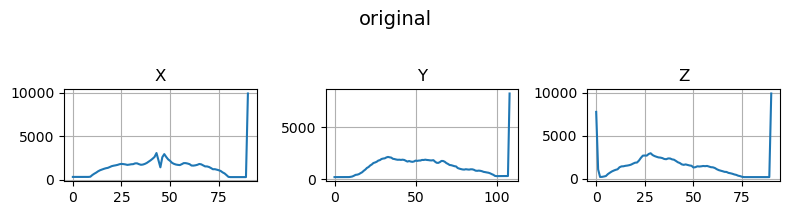

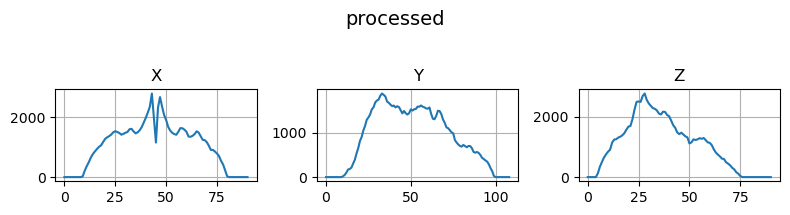

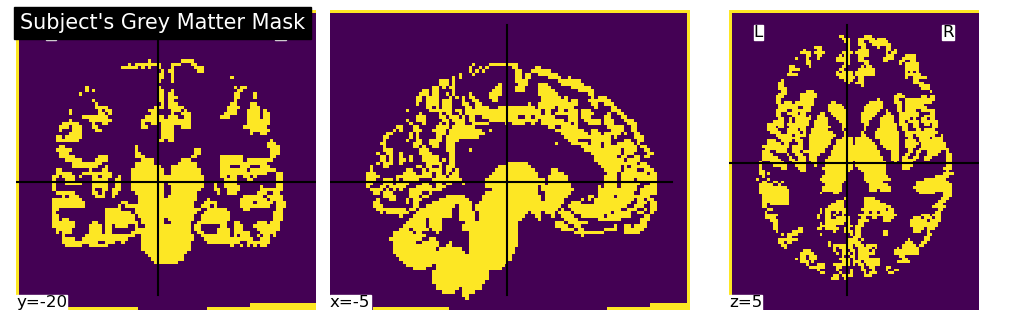

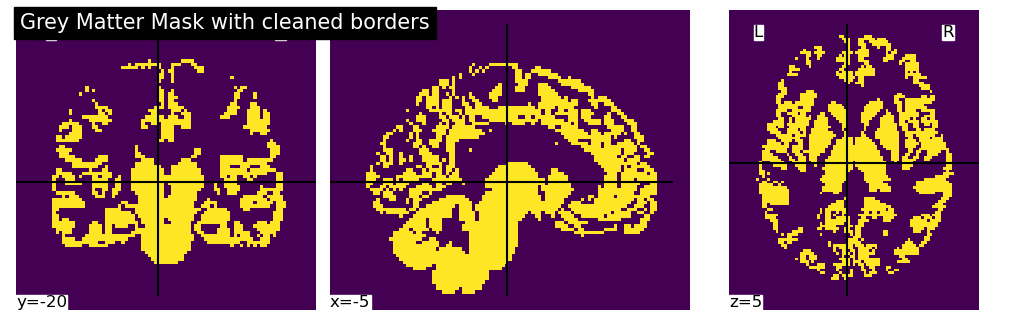

In [16]:
process_gray_matter_mask(anat_dir, f"{127630}", border_size=5, save=True, plot=True)

In [14]:
#VALE

subjects_ko = [123925, 124422, 151223, 135225, 151627, 160123]
subjects_to_check = [159340, 160123, 163129, 176542, 178950, 188347]
subjects_ok = [130013, 127630, 122620, 176542, 159340]
 
acquisition_LR = "LR"
acquisition_RL = "RL"
tasktype = "MOTOR"



selecting subject gray matter mask
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
concatenating volumes for task MOTOR
files 127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
fitting GLM for task MOTOR
computing fmap
Threshold not specified, automatically compute threshold


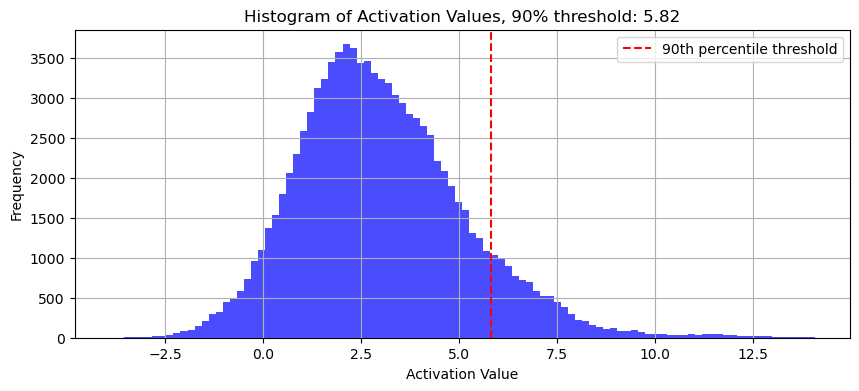

threshold: 5.817742256503082


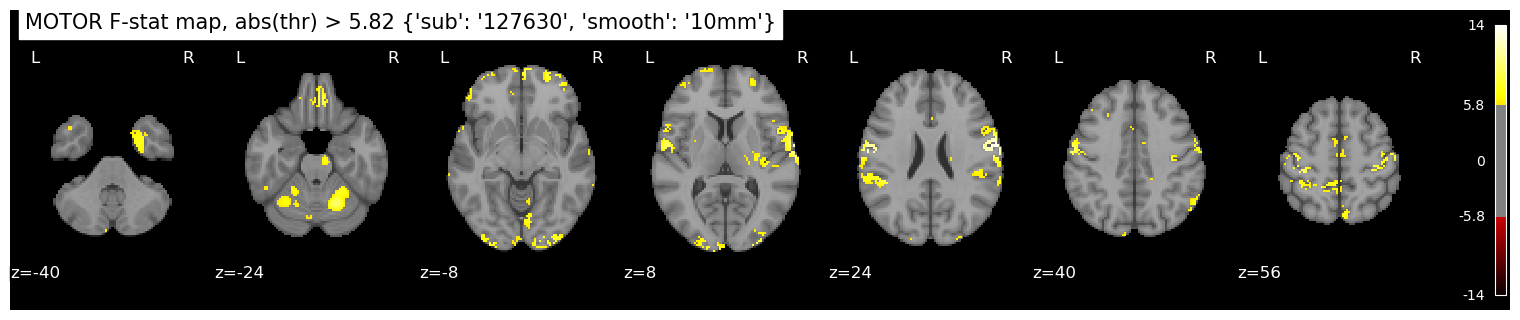

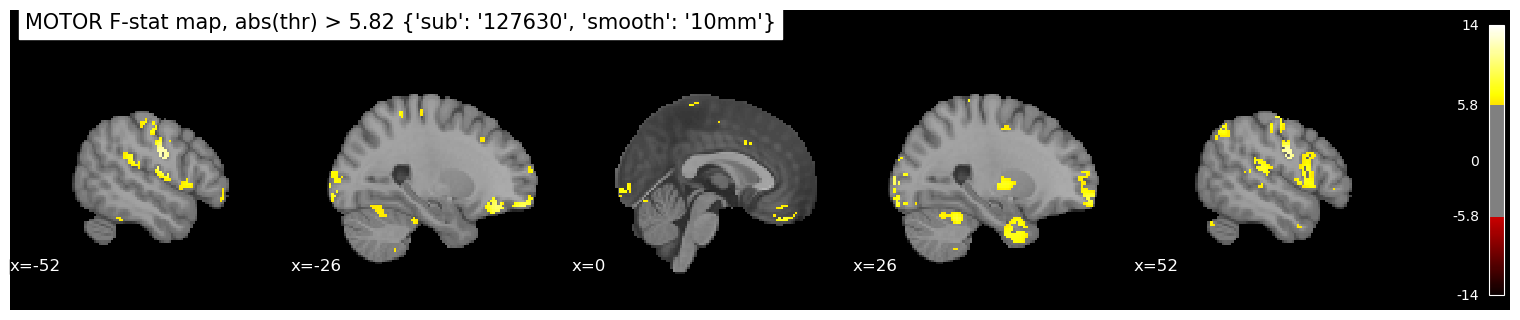

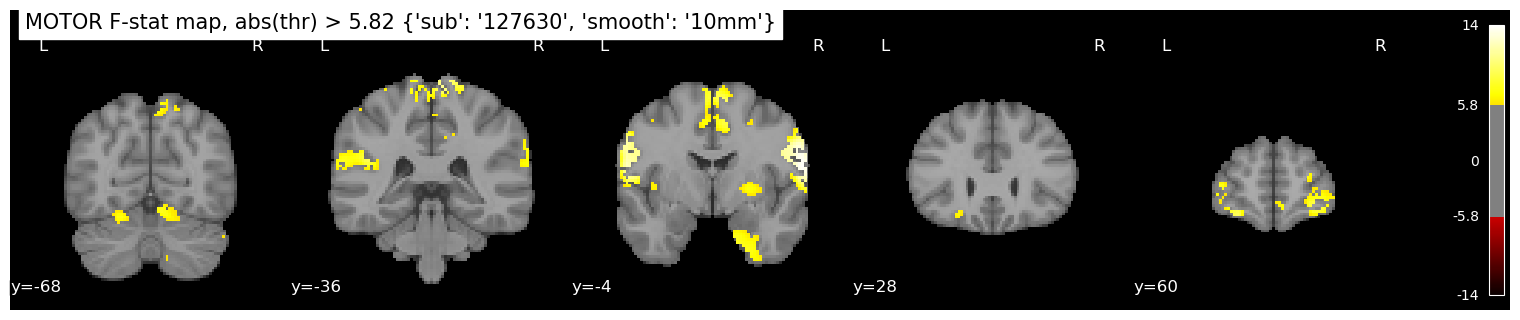

In [55]:
show_task_activation(f"{127630}", "MOTOR", "RL", smoothing=10, plot_designmatrix=False,
                               threshold=None, plot_glass=False,bins_perc=90)

In [ ]:
for subject in subjects_ko:
    show_task_activation(f"{123925}", tasktype, acquisition_RL, smoothing=10, plot_designmatrix=False,
                               threshold=None, plot_glass=True,bins_perc=98)
    

In [16]:
def get_subject_ids(paradigm_dir):
    subject_ids = []
    if os.path.exists(paradigm_dir):
        for file_name in os.listdir(paradigm_dir):
            if file_name.endswith(".mat"):
                subject_id = file_name.split('_')[0]
                subject_ids.append(subject_id)
    return sorted(set(subject_ids))

subject_ids = get_subject_ids(paradigm_dir)
print("Soggetti trovati nella directory:")
for subject_id in subject_ids:
    print(subject_id)

Soggetti trovati nella directory:
100307
100408
101107
101309
101915
103111
103414
103818
105014
105115
106016
108828
110411
111312
111716
113619
113922
114419
115320
116524
117122
118528
118730
118932
120111
122317
122620
123117
123925
124422
125525
126325
127630
127933
128127
128632
129028
130013
130316
131217
131722
133019
133928
135225
135932
136833
138534
139637
140925
144832
146432
147737
148335
148840
149337
149539
149741
151223
151526
151627
153025
154734
156637
159340
160123
161731
162733
163129
176542
178950
188347
189450
190031
192540
196750
198451
199655
201111
208226
211417
211720
212318
214423
221319
239944
245333
280739
298051
366446
397760
414229
499566
654754
672756
751348
756055
792564
856766
857263
899885


In [ ]:
subjects_ok[127630]
subjects_maybe[130013, 122620]
subjects_ko[]